In [224]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import os

In [225]:
DIRECTORY = "../raw_results/trace_spin"

In [226]:
def split_bench_name(s):
    s = s.split("_")
    prefix = []
    for part in s:
        if part.islower():
            prefix.append(part)
        else:
            break
    return "_".join(prefix), "_".join(s[len(prefix):])

In [227]:
results_by_mode = {}
for filename in os.listdir(DIRECTORY):
    f = os.path.join(DIRECTORY, filename)
    with open(f, 'r') as file:
        pref, mode = split_bench_name(filename.split(".")[0])
        results_by_mode[mode] = json.load(file)

In [228]:
total_times = {mode: res["results"][-1]["end"] + res["results"][-1]["start"] - res["results"][0]["start"] for mode, res in results_by_mode.items()}

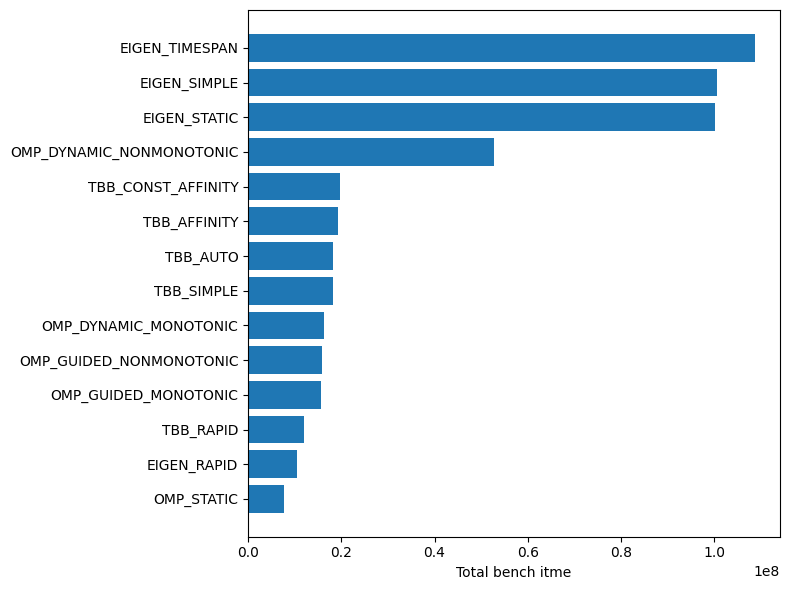

In [229]:
def plot_dict(dicts, titles):
    if isinstance(dicts, dict):
        dicts = [dicts]
    if isinstance(titles, str):
        titles = [titles]
    count = len(dicts)
    fig, axis = plt.subplots(1, count, squeeze=False, figsize=(count*8, 6))
    for i, d in enumerate(dicts):
        d = dict(sorted(d.items(), key=lambda item: item[1]))
        axis[0][i].barh(range(len(d)), list(d.values()), align='center')
        axis[0][i].set_yticks(range(len(d)), list(d.keys()))
        axis[0][i].set_xlabel(titles[i])
    fig.tight_layout()

plot_dict(total_times, "Total bench itme")

In [230]:
sum_of_max_starts = {mode: sum(max(min(t["trace"]["execution_start"] for t in tasks) for _, tasks in iter["tasks"].items()) for iter in res["results"]) for mode, res in results_by_mode.items()}

In [231]:
starts = {mode: [[[t["trace"]["execution_start"] for t in tasks] for _, tasks in iter["tasks"].items()] for iter in res["results"]] for mode, res in results_by_mode.items()}

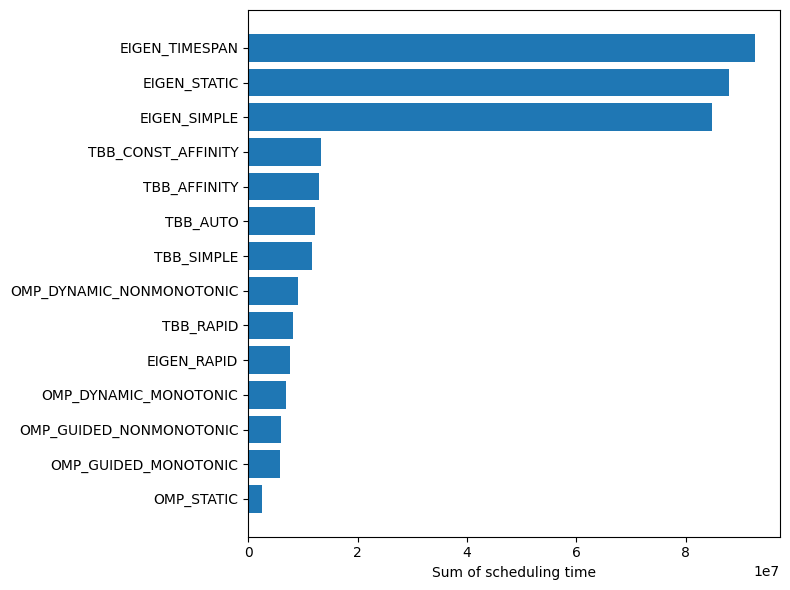

In [232]:
plot_dict(sum_of_max_starts, "Sum of scheduling time")

In [233]:
mean_start = {mode: np.mean([np.mean([min(t["trace"]["execution_start"] for t in tasks) for _, tasks in iter["tasks"].items()]) for iter in res["results"]]) for mode, res in results_by_mode.items()}

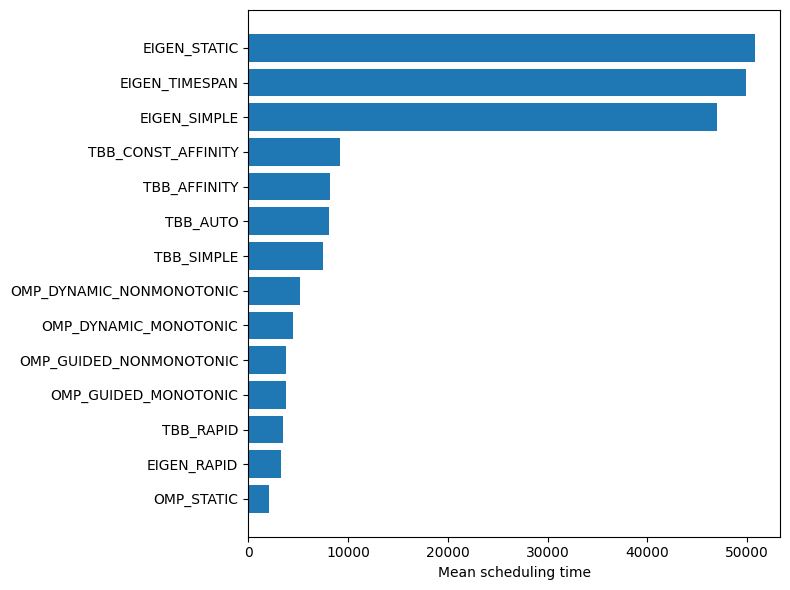

In [234]:
plot_dict(mean_start, "Mean scheduling time")

In [235]:
sum_of_max_ends = {mode: sum(max(iter["end"] - max(t["trace"]["execution_end"] for t in tasks) for _, tasks in iter["tasks"].items()) for iter in res["results"]) for mode, res in results_by_mode.items()}

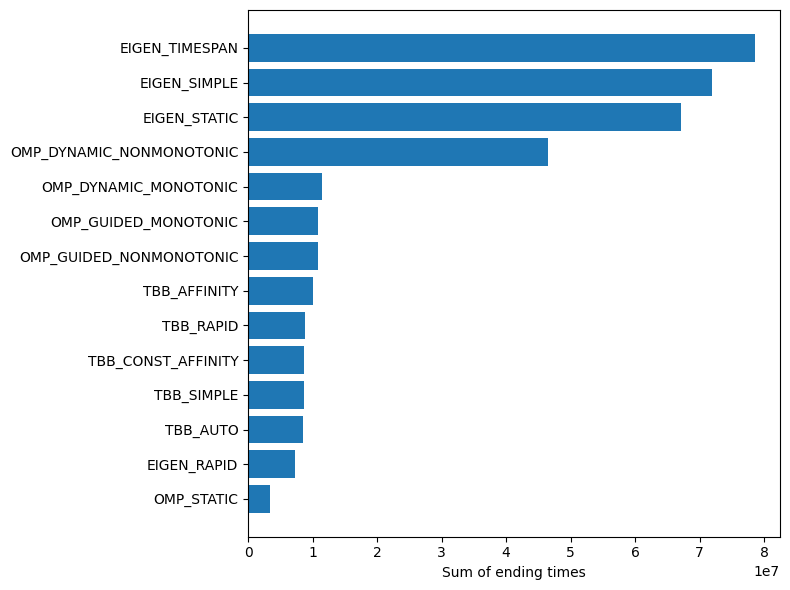

In [236]:
plot_dict(sum_of_max_ends, "Sum of ending times")

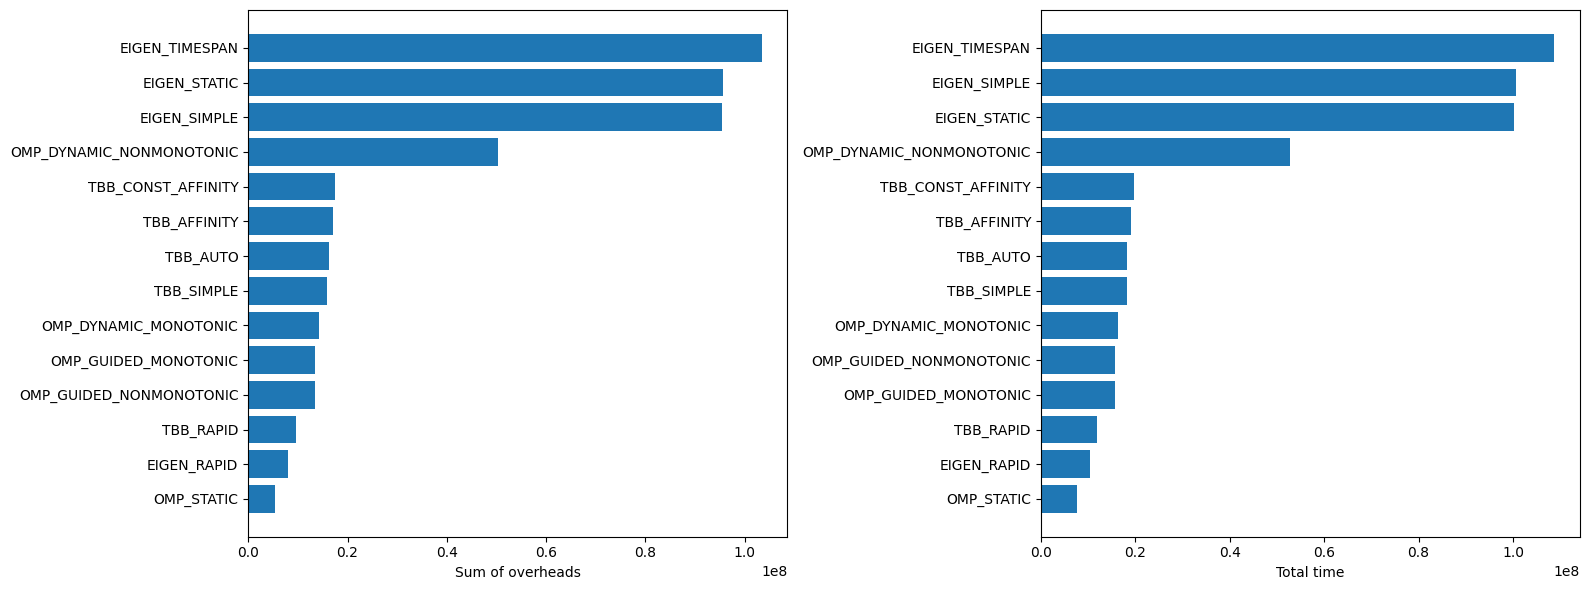

In [237]:
sum_of_overheads = {mode: sum(max(max(iter["end"] - t["trace"]["execution_end"] + t["trace"]["execution_start"] for t in tasks) for _, tasks in iter["tasks"].items()) for iter in res["results"]) for mode, res in results_by_mode.items()}
plot_dict([sum_of_overheads, total_times], ["Sum of overheads", "Total time"])

In [238]:
# convert json to pandas dataframe with next columns:
# iteration, start, end, thread_id, task_idx, prev_trace, execution_start, execution_end, cpu
# from array with iterations with next structure: (start, end, {thread_id -> executed tasks})
df = pd.DataFrame(columns=['iteration', 'start', 'end', 'thread_id', 'task_idx', 'prev_trace', 'execution_start', 'execution_end', 'cpu'])
for iteration, iteration_data in enumerate(results):
    iteration_start = iteration_data["start"]
    iteration_end = iteration_data["end"]
    for thread_id, thread_tasks in iteration_data["tasks"].items():
        for task in thread_tasks:
            task_idx = task["index"]
            trace = task["trace"]
            prev_trace = trace["prev_trace"]
            execution_start = trace["execution_start"]
            execution_end = trace["execution_end"]
            cpu = task["cpu"]
            new_df = pd.DataFrame([{
                'iteration': iteration,
                'start': iteration_start,
                'end': iteration_end,
                'thread_id': thread_id,
                'task_idx': task_idx,
                'prev_trace': prev_trace,
                'execution_start': execution_start,
                'execution_end': execution_end,
                'execution': execution_end - execution_start,
                'cpu': cpu
            }])
            df = pd.concat([df, new_df], ignore_index=True)

NameError: name 'results' is not defined

In [ ]:
df.head()

,iteration,start,end,thread_id,task_idx,prev_trace,execution_start,execution_end,cpu,execution
0,0,15841789666928,15845560731524,10,727,15844810137126,15844810142432,15844847562336,20,37419904.0
1,0,15841789666928,15845560731524,10,728,15844847562360,15844847562914,15844885216872,20,37653958.0
2,0,15841789666928,15845560731524,10,729,15844885216916,15844885217284,15844922881412,20,37664128.0
3,0,15841789666928,15845560731524,10,730,15844922881436,15844922883062,15844960540504,20,37657442.0
4,0,15841789666928,15845560731524,10,731,15844960540528,15844960540996,15844998202968,20,37661972.0


In [ ]:
ends = df[df.iteration == 9].groupby("thread_id")["execution_end"].max()
execs = df[df.iteration == 9].groupby("thread_id")["execution"].max()

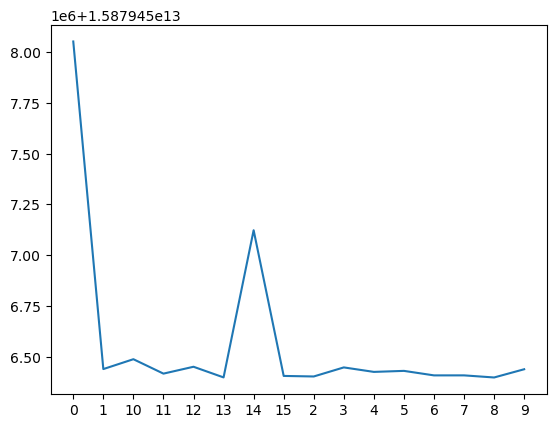

In [ ]:
plt.plot(ends)

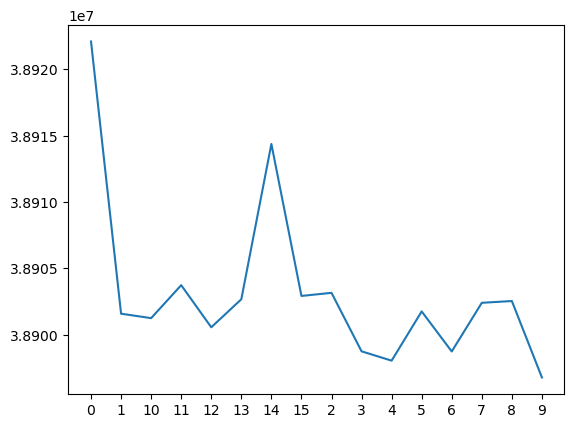

In [ ]:
plt.plot(execs)